# 데이터 결측치 처리

앞서 간단한 결측치 처리를 진행했지만, EDA를 통해서 추가적인 결측치 처리의 필요성을 알게되었습니다.  
결측치 처리는 다음과 같은 순서로 진행됩니다. 
1. dvc_ctg_nm : `기기 유형` 처리
2. trfc_src : `유입 채널` 처리
<br><br>

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.font_manager as fm
path = 'data/font/NanumGothic-ExtraBold.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

## load data

In [16]:
cks_dtype = {'clnt_id':'int64','sess_id':'int64','hit_seq':'int64','action_type':'int64','biz_unit':'category','sess_dt':'object','hit_tm':'object',
             'hit_pss_tm':'int64','trans_id':'float64','sech_kwd':'object','tot_pag_view_ct':'float64','tot_sess_hr_v':'float64','trfc_src':'category',
             'dvc_ctg_nm':'object','pd_c':'object','de_dt':'object','de_tm':'object','buy_am':'int64','buy_ct':'int64','clnt_gender':'category'}

online = pd.read_csv('./data/online_01.csv', dtype=cks_dtype)
trade = pd.read_csv('./data/trade_01.csv', dtype=cks_dtype)
customer = pd.read_csv('./data/customer_01.csv', dtype=cks_dtype)
item = pd.read_csv('./data/item_01.csv', dtype=cks_dtype)

### dvc_ctg_nm : 기기 유형 

 * mobile_web / mobile_app / PC

In [17]:
online_A03 = online[online['biz_unit']=='A03']
online_A02 = online[online['biz_unit']=='A02']
online_A01 = online[online['biz_unit']=='A01']

In [6]:
online_A03['dvc_ctg_nm'].value_counts().sort_index()

PC             150421
mobile_web     398935
unknown       1782081
Name: dvc_ctg_nm, dtype: int64

In [7]:
online_A02['dvc_ctg_nm'].value_counts().sort_index()

PC             77617
mobile_app    359902
mobile_web    230121
unknown          453
Name: dvc_ctg_nm, dtype: int64

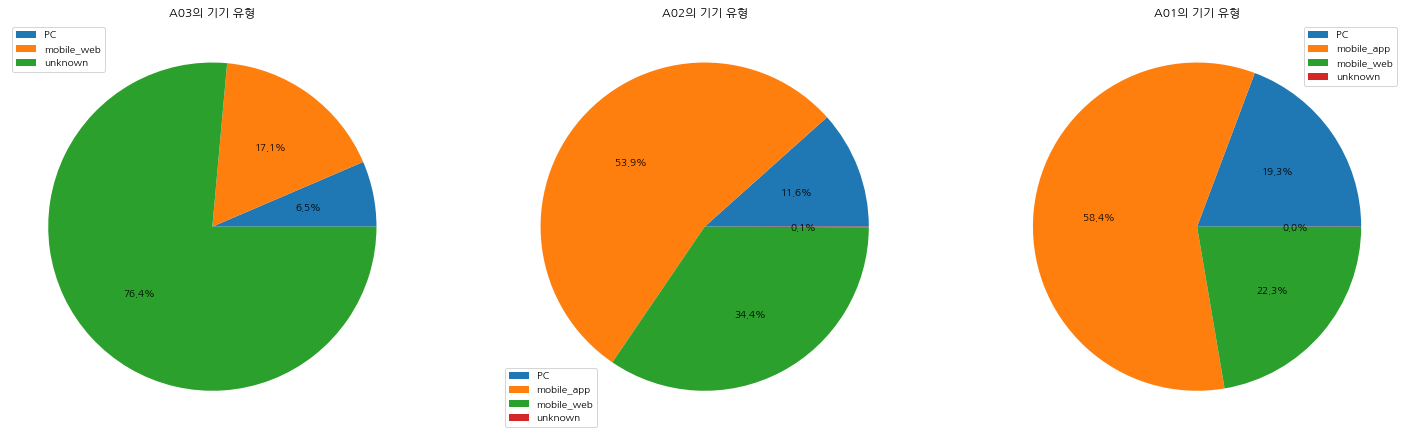

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(25, 8))
labels1 = ['PC', 'mobile_web', 'unknown']
labels = ['PC', 'mobile_app', 'mobile_web', 'unknown']

axs[0].pie(online_A03['dvc_ctg_nm'].value_counts().sort_index(), autopct='%0.1f%%')
axs[0].legend(labels1)
axs[0].set_title('A03의 기기 유형')

axs[1].pie(online_A02['dvc_ctg_nm'].value_counts().sort_index(), autopct='%0.1f%%')
axs[1].legend(labels)
axs[1].set_title('A02의 기기 유형')

axs[2].pie(online_A01['dvc_ctg_nm'].value_counts().sort_index(), autopct='%0.1f%%')
axs[2].legend(labels)
axs[2].set_title('A01의 기기 유형')

plt.show()

<br><br>
#### 1-13-1. 결측치 처리
A03의 기기에 유일하게 mobile-app의 정보가 없다.
- A03의 unknown 데이터는 mobile_app으로 변경

In [22]:
online.loc[online['dvc_ctg_nm']=='unknown', 'dvc_ctg_nm'] = 'mobile_app'

In [23]:
online_A03 = online[online['biz_unit']=='A03']
online_A02 = online[online['biz_unit']=='A02']
online_A01 = online[online['biz_unit']=='A01']

In [24]:
online_A03['dvc_ctg_nm'].value_counts().sort_index()

PC             150421
mobile_app    1782081
mobile_web     398935
Name: dvc_ctg_nm, dtype: int64

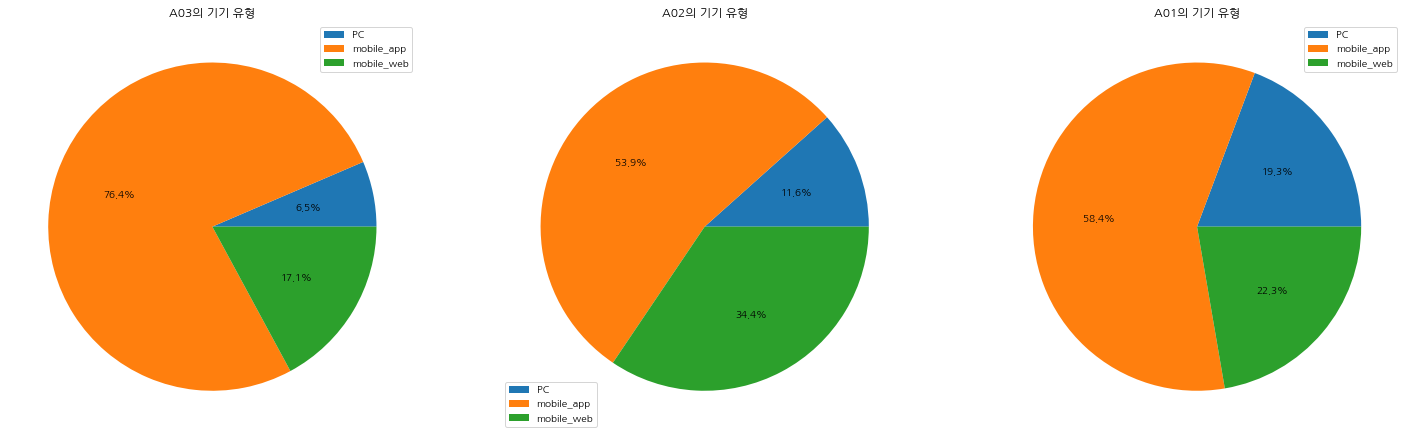

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(25, 8))
labels1 = ['PC', 'mobile_app',  'mobile_web']
labels2 = ['PC', 'mobile_app', 'mobile_web',  'unknown']

axs[0].pie(online_A03['dvc_ctg_nm'].value_counts().sort_index(), autopct='%0.1f%%')
axs[0].legend(labels1)
axs[0].set_title('A03의 기기 유형')

axs[1].pie(online_A02['dvc_ctg_nm'].value_counts().sort_index(), autopct='%0.1f%%')
axs[1].legend(labels2)
axs[1].set_title('A02의 기기 유형')

axs[2].pie(online_A01['dvc_ctg_nm'].value_counts().sort_index(), autopct='%0.1f%%')
axs[2].legend(labels2)
axs[2].set_title('A01의 기기 유형')

plt.show()

<br><br>
### trfc_src : 유입 채널 

 * 종류 : DIRECT / PUSH / WEBSITE / PORTAL_1 / PORTAL_2 / PORTAL_3 / unknown

 * 유입채널의 종류는 몇 개나 있는가?? => 7개

In [26]:
online['trfc_src'].nunique()

7

 * 유입채널 별 온라인 행동데이터는 몇 건이 있는지? => 최대 171만건 , 최소 9792건

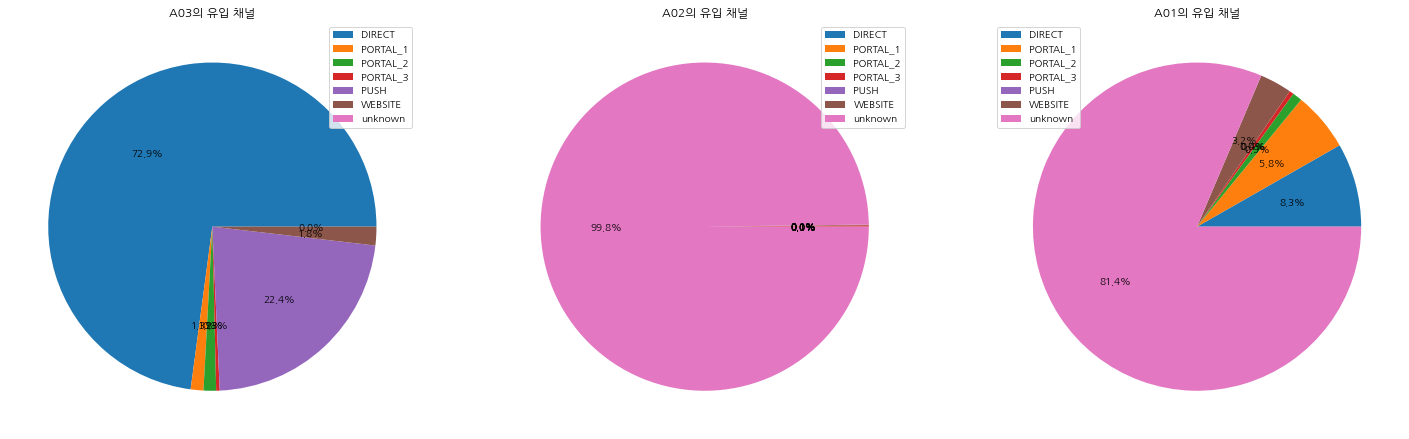

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(25, 8))
labels = ['DIRECT', 'PORTAL_1', 'PORTAL_2', 'PORTAL_3', 'PUSH', 'WEBSITE', 'unknown']

axs[0].pie(online_A03['trfc_src'].value_counts().sort_index(), autopct='%0.1f%%')
axs[0].legend(labels)
axs[0].set_title('A03의 유입 채널')

axs[1].pie(online_A02['trfc_src'].value_counts().sort_index(), autopct='%0.1f%%')
axs[1].legend(labels)
axs[1].set_title('A02의 유입 채널')

axs[2].pie(online_A01['trfc_src'].value_counts().sort_index(), autopct='%0.1f%%')
axs[2].legend(labels)
axs[2].set_title('A01의 유입 채널')

plt.show()

<br><br>
#### 1-14-1. 결측치 처리
기기 유형으로 유입채널의 unknown 데이터를 임의로 채울 수 있을 것 같습니다.  
다음과 같은 순서로 진행됩니다.  
- A03를 기반으로 A01의 unknown 데이터 채우기
- 관계를 분석한 기반으로 unknown 데이터 채우기

In [28]:
import random
def random_choise(data, dvc):
    x = data.copy()
    c_nm2_choiced = []
    data_dvc = online_A03[online_A03['dvc_ctg_nm'] == dvc]['trfc_src']
    c_nm2_list = data_dvc.value_counts().index
    probs = list(data_dvc.value_counts() / data_dvc.count())
    for i in x.index:
        if (x.loc[i,['trfc_src']] == 'unknown')['trfc_src']:
            x.loc[i,['trfc_src']] = random.choices(c_nm2_list, weights = probs)[0]
    return x

In [29]:
def change_trfc(dvc):
    online_A02_app = online_A02[online_A02['dvc_ctg_nm'] == dvc]
    online_A01_app = online_A01[online_A01['dvc_ctg_nm'] == dvc]

    online_A02[online_A02['dvc_ctg_nm'] == dvc] = random_choise(online_A02_app, dvc)
    online_A01[online_A01['dvc_ctg_nm'] == dvc] = random_choise(online_A01_app, dvc)

In [30]:
def plot_trfc(dvc):
    fig, axs = plt.subplots(3, 1, figsize=(8,6))
    plt.subplots_adjust(hspace=0.8)
    sns.countplot(online_A03[online_A03['dvc_ctg_nm'] == dvc]['trfc_src'], ax=axs[0]).set_title('A03_'+dvc)
    sns.countplot(online_A02[online_A02['dvc_ctg_nm'] == dvc]['trfc_src'], ax=axs[1]).set_title('A02_'+dvc)
    sns.countplot(online_A01[online_A01['dvc_ctg_nm'] == dvc]['trfc_src'], ax=axs[2]).set_title('A01_'+dvc)

- mobile_app을 기준으로 채우기

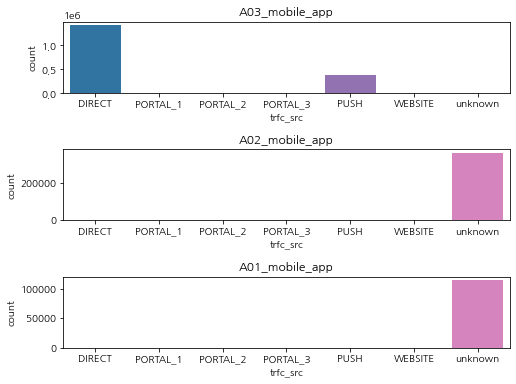

In [31]:
dvc = 'mobile_app'
plot_trfc(dvc)

mobile_app으로 들어올 수 있는 유입 경로는 DIRECT와 PUSH가 있습니다. 

In [32]:
change_trfc(dvc)

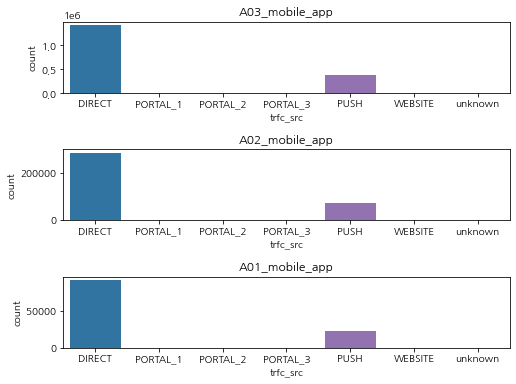

In [33]:
plot_trfc(dvc)

A02와 A01 모두 A03의 그래프와 비슷하게 채워졌습니다. 

- PC를 기준으로 채우기 

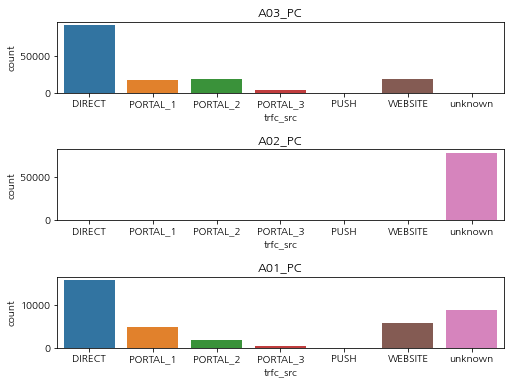

In [34]:
dvc = 'PC'
plot_trfc(dvc)

In [35]:
change_trfc(dvc)

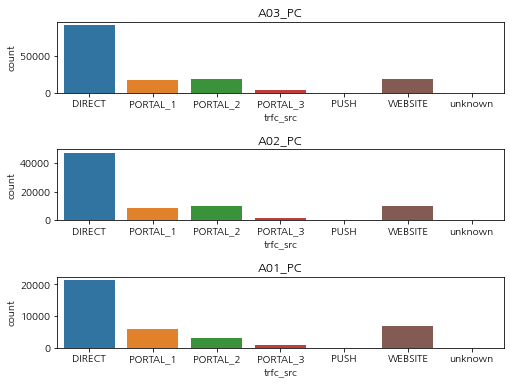

In [36]:
plot_trfc(dvc)

- mobile_web를 기준으로 채우기

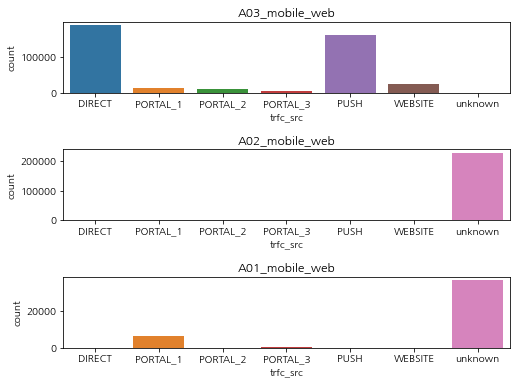

In [37]:
dvc = 'mobile_web'
plot_trfc(dvc)

In [38]:
change_trfc(dvc)

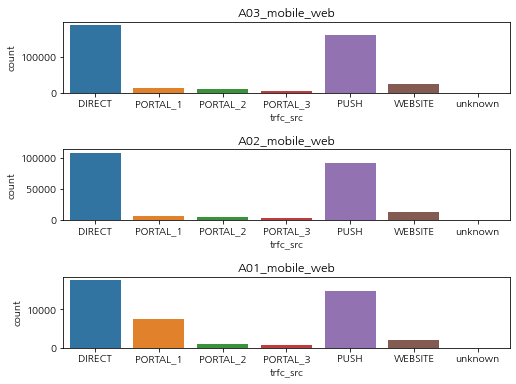

In [39]:
plot_trfc(dvc)

In [21]:
online_A03 = online[online['biz_unit']=='A03']
online_A02 = online[online['biz_unit']=='A02']
online_A01 = online[online['biz_unit']=='A01']

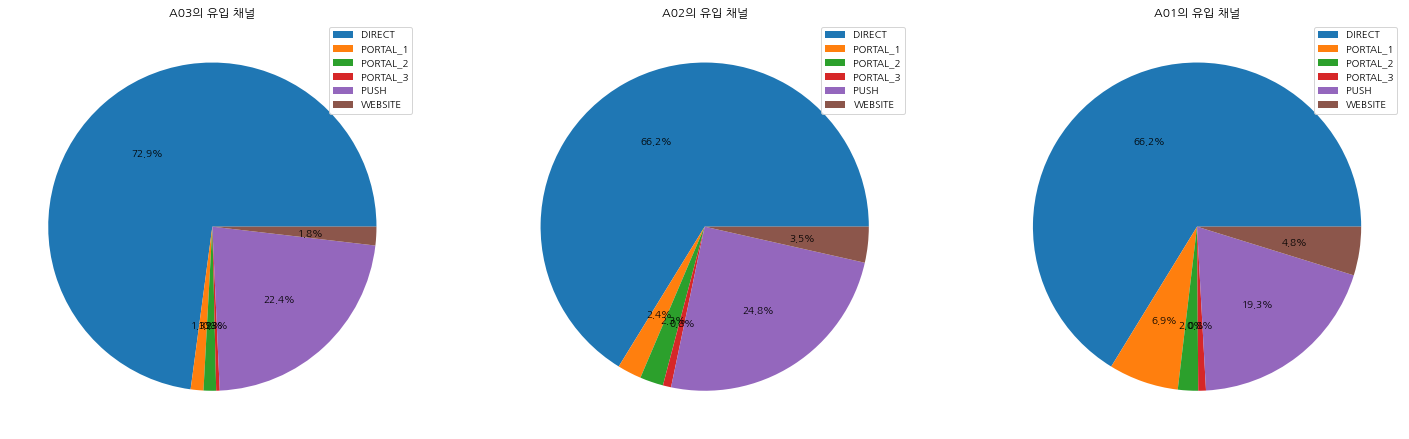

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(25, 8))
labels = ['DIRECT', 'PORTAL_1', 'PORTAL_2', 'PORTAL_3', 'PUSH', 'WEBSITE', 'unknown']

axs[0].pie(online_A03['trfc_src'].value_counts().sort_index(), autopct='%0.1f%%')
axs[0].legend(labels)
axs[0].set_title('A03의 유입 채널')

axs[1].pie(online_A02['trfc_src'].value_counts().sort_index(), autopct='%0.1f%%')
axs[1].legend(labels)
axs[1].set_title('A02의 유입 채널')

axs[2].pie(online_A01['trfc_src'].value_counts().sort_index(), autopct='%0.1f%%')
axs[2].legend(labels)
axs[2].set_title('A01의 유입 채널')

plt.show()

In [40]:
online = pd.concat([online_A01,online_A02,online_A03])

In [42]:
online.to_csv('./data/online_03.csv', index=False)

In [20]:
online = pd.read_csv('./data/online_03.csv')